In [22]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image

plt.rcParams['figure.figsize'] = (16, 9)

## First Image Fretboard Corners

In [23]:
img1 = cv2.imread('../data/fretboard_dataset/fretboard_frames_test/28_0.png')
img2 = cv2.imread('../data/fretboard_dataset/fretboard_frames_test/28_1.png')

# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "test" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
image_fns = os.listdir(images_path)
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
f = open(json_fn)
data = json.load(f) # data is dict of json contents
k = list(data.keys())

for i, fn in enumerate(image_fns):
    if i == 0:
        img_path = os.path.join(images_path, fn)
        out_path = os.path.join(images_path, "annotated_"+fn)
        img = np.asarray(Image.open(img_path)) # loads images w/ range of 0:255
        x_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
        y_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_y"]
        x_list.pop(-1) # remove duplicate of first coordinate from end of lists
        y_list.pop(-1)
        poly_corners = np.asarray([list(zip(x_list, y_list))], dtype=np.int32) # repackage into np array w/ correct dtype



In [24]:
def modified_RANSAC(img1, img2, input_corners):
    # First find the minX minY maxX and maxY of the polygon
    minX = img1.shape[1]
    maxX = -1
    minY = img1.shape[0]
    maxY = -1
    for point in poly_corners[0]:

        x = point[0]
        y = point[1]

        if x < minX:
            minX = x
        if x > maxX:
            maxX = x
        if y < minY:
            minY = y
        if y > maxY:
            maxY = y

    # Go over the points in the image if thay are out side of the emclosing rectangle put zero
    # if not check if thay are inside the polygon or not
    cropedImage = np.zeros_like(img1)
    for y in range(0,img1.shape[0]):
        for x in range(0, img1.shape[1]):
            if x < minX or x > maxX or y < minY or y > maxY:
                continue

            if cv2.pointPolygonTest(np.asarray(poly_corners),(x,y),False) >= 0:
                cropedImage[y, x, 0] = img1[y, x, 0]
                cropedImage[y, x, 1] = img1[y, x, 1]
                cropedImage[y, x, 2] = img1[y, x, 2]
                
    img1 = cropedImage
    
    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kps1, des1 = sift.detectAndCompute(img1, None)
    kps2, des2 = sift.detectAndCompute(img2, None)

    # Create a KD-tree for the descriptors of the first image
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test to get good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw the matched lines on the stacked image
    lines = []
    for match in good_matches:
        pt1 = (int(kps1[match.queryIdx].pt[0]), int(kps1[match.queryIdx].pt[1]))
        pt2 = (int(kps2[match.trainIdx].pt[0]), int(kps2[match.trainIdx].pt[1] + img1.shape[0]))  # Shift the y-coordinate for the second image
        lines.append([pt1[0], pt1[1], pt2[0], pt2[1]])

    # Remove lines that cross a large number of other lines
    filtered_lines = []
    filtered_idx = []
    for i in range(len(lines)):
        crossing_count = 0
        for j in range(len(lines)):
            if i != j:
                x1, y1, x2, y2 = lines[i]
                x3, y3, x4, y4 = lines[j]
                # Check if line i crosses 70% of the other lines
                if (
            min(x1, x2) < max(x3, x4) and
            min(y1, y2) < max(y3, y4) and
            min(x3, x4) < max(x1, x2) and
            min(y3, y4) < max(y1, y2) and
            ((x1 - x2) * (y3 - y1) - (y1 - y2) * (x3 - x1)) * ((x1 - x2) * (y4 - y1) - (y1 - y2) * (x4 - x1)) < 0
        ):
                    crossing_count += 1

        if crossing_count < .7 * len(lines):
            filtered_lines.append(lines[i])
        else:
            filtered_idx.append(i)

    # Extract source and destination points
    src_pts = np.array([kps1[match.queryIdx].pt for match in good_matches if good_matches.index(match) not in filtered_idx])
    dst_pts = np.array([kps2[match.trainIdx].pt for match in good_matches if good_matches.index(match) not in filtered_idx])

    # Find the homography matrix using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC)

    # Define the 4-point polygon
    polygon = np.asarray(input_corners, dtype=np.float32).reshape(-1, 1, 2)
    # Apply the homography to the polygon
    transformed_polygon = cv2.perspectiveTransform(polygon, M)

    # Convert the transformed polygon to a list of tuples for drawing
    transformed_polygon = transformed_polygon.squeeze().tolist()

    # Display the result
    return transformed_polygon
    

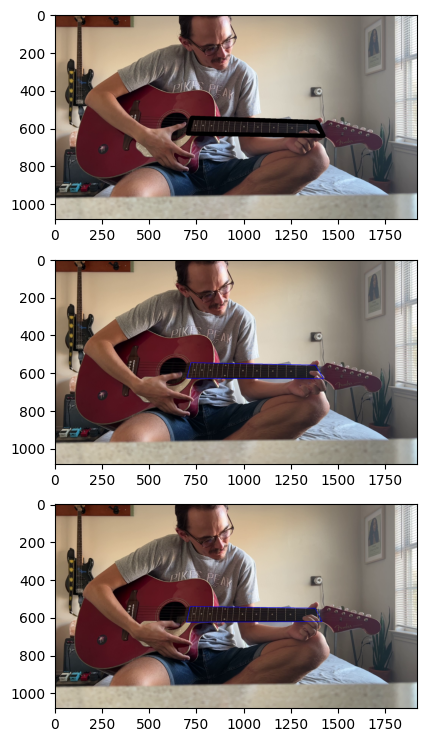

In [27]:
img3 = cv2.imread('../data/fretboard_dataset/fretboard_frames_test/28_2.png')
img4 = cv2.imread('../data/fretboard_dataset/fretboard_frames_test/28_3.png')

img2_ = img2.copy()
img3_ = img3.copy()
img4_ = img4.copy()
fig, axs = plt.subplots(3, 1)

transformed_polygon_1 = modified_RANSAC(img1, img2, poly_corners)
cv2.polylines(img2_, [np.int32(transformed_polygon_1)], isClosed=True, color=(0,0,255), thickness=10)

transformed_polygon_2 = modified_RANSAC(img2, img3, transformed_polygon_1)
cv2.polylines(img3_, [np.int32(transformed_polygon_2)], isClosed=True, color=(0,0,255), thickness=10)

transformed_polygon_3 = modified_RANSAC(img3, img4, transformed_polygon_2)
cv2.polylines(img4_, [np.int32(transformed_polygon_3)], isClosed=True, color=(0,0,255), thickness=10)

axs[0].imshow(cv2.cvtColor(img2_, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img3_, cv2.COLOR_BGR2RGB))
axs[2].imshow(cv2.cvtColor(img4_, cv2.COLOR_BGR2RGB))
plt.show()